In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sys
from sklearn.linear_model import LinearRegression


def read_file(filename):
    return pd.read_csv(filename, index_col=0, parse_dates=True, infer_datetime_format=True)


def get_data(timeframe, name):
    return read_file("data_with_new_indicators/btcusdt_" + timeframe + "_" + name + ".csv")

time_frame = "1h"


df_train = get_data(time_frame, "train")
df_val = get_data(time_frame, "val")

/tmp/ipykernel_53541/2344949047.py:9: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  return pd.read_csv(filename, index_col=0, parse_dates=True, infer_datetime_format=True)
/tmp/ipykernel_53541/2344949047.py:9: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  return pd.read_csv(filename, index_col=0, parse_dates=True, infer_datetime_format=True)


In [45]:
# Divide the dataframe into 2 segments
df_train['date_time'] = list(pd.to_datetime(pd.Series(df_train.index)))
df_val['date_time'] = list(pd.to_datetime(pd.Series(df_val.index)))
# type(df_train['date_time'].between_time('00:30', '11:30'))
df_train.head()

,open,close,volume,Daily_Return,Next_2_Days_Return,RSI,exp_RSI,EMA_Slope,date_time
datetime,,,,,,,,,
2018-01-01 05:30:00,13715.65,13529.01,443.356199,0.000000,-14.696567,0.0,0.01476,0.000674,2018-01-01 05:30:00
2018-01-01 06:30:00,13528.99,13203.06,383.697006,-24.092672,15.675911,0.0,0.01476,0.000674,2018-01-01 06:30:00
2018-01-01 07:30:00,13203.00,13330.18,429.064572,9.628071,20.317055,0.0,0.01476,0.289932,2018-01-01 07:30:00
2018-01-01 08:30:00,13330.26,13410.03,420.087030,5.990167,11.108103,0.0,0.01476,-0.548073,2018-01-01 08:30:00
2018-01-01 09:30:00,13434.98,13601.01,340.807329,14.241579,13.190197,0.0,0.01476,-1.719884,2018-01-01 09:30:00


In [26]:
# Divide segments based on datetime
# filter1 = df_train['datetime'].isin(df_train['datetime'].between_time('00:30', '11:30'))
# df_train['datetime'].isin(df_train['datetime'].between_time('12:30', '23:30'))
df_train = get_data("1h", "train")
df_val = get_data("1h", "val")

df_train['date_time'] = list(pd.to_datetime(pd.Series(df_train.index)))
df_val['date_time'] = list(pd.to_datetime(pd.Series(df_val.index)))

tr_segment1 = df_train[df_train['date_time'].isin(df_train['date_time'].between_time('00:30', '11:30'))]
tr_segment2 = df_train[df_train['date_time'].isin(df_train['date_time'].between_time('12:30', '23:30'))]
tr_segments = [tr_segment1, tr_segment2]
models = [None for x in tr_segments]

for i in range(len(tr_segments)):
    df = tr_segments[i]
    X = df[['volume', 'Daily_Return', 'RSI', 'exp_RSI', 'EMA_Slope']]
    Y = df['Next_2_Days_Return']
    models[i] = LinearRegression()
    models[i].fit(X,Y)
    tr_segments[i]['pred'] = models[i].predict(X)
    # tr_segments[i].drop(['date_time'], axis=1)

# Merge tr_segments['pred'] into df_train['pred'] based on date_time column
# df_train.drop(['date_time'], axis=1)
df_train = df_train.merge(tr_segments[0][['date_time', 'pred']], on='date_time', how='left')
df_train = df_train.merge(tr_segments[1][['date_time', 'pred']], on='date_time', how='left')
df_train['pred'] = df_train['pred_x'].fillna(df_train['pred_y'])
df_train = df_train.drop(['pred_x', 'pred_y'], axis=1)
# df_train.head(), tr_segments[0].head()

/tmp/ipykernel_5564/2344949047.py:9: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  return pd.read_csv(filename, index_col=0, parse_dates=True, infer_datetime_format=True)
/tmp/ipykernel_5564/2344949047.py:9: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  return pd.read_csv(filename, index_col=0, parse_dates=True, infer_datetime_format=True)
/tmp/ipykernel_5564/519075906.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [27]:
# y_pred = model.predict(X_train)
quantile_value = np.quantile(np.abs(df_train['pred']), 0.93)
print("quantile value: ", quantile_value)
print(np.corrcoef(df_train['pred'], df_train['Next_2_Days_Return'])[0,1])
y_pred = df_train['pred']
# quantile_value = 1.5


df_train['indicator'] = np.where(y_pred > quantile_value, 1, np.where(y_pred < -quantile_value, -1, 0))
data_train = df_train
tot = 0
for index, _ in data_train.iterrows():
    data_train.at[index, 'signal'] = 0
    if data_train.at[index, 'indicator'] == 1:
        if tot == 0 or tot == -1:
            # enter long position/exit short position
            tot += 1
            data_train.at[index, 'signal'] = 1
    elif data_train.at[index, 'indicator'] == -1:
        if tot == 0 or tot == 1:
            # enter short position/exit long position
            tot -= 1
            data_train.at[index, 'signal'] = -1
    data_train['datetime'] = data_train['date_time']
data_train.to_csv("../src/logs/lin_reg_train_" + time_frame + ".csv")




quantile value:  1.669319827210385
0.11182140608849571


In [28]:
# Continue with the remaining code
val_segment1 = df_val[df_val['date_time'].isin(df_val['date_time'].between_time('00:30', '11:30'))]
val_segment2 = df_val[df_val['date_time'].isin(df_val['date_time'].between_time('12:30', '23:30'))]
val_segments = [val_segment1, val_segment2]

for i in range(len(val_segments)):
    df = val_segments[i]
    X = df[['volume', 'Daily_Return', 'RSI', 'exp_RSI', 'EMA_Slope']]
    Y = df['Next_2_Days_Return']
    val_segments[i]['pred'] = models[i].predict(X)

# Merge val_segments['pred'] into df_val['pred'] based on date_time column
df_val = df_val.merge(val_segments[0][['date_time', 'pred']], on='date_time', how='left')
df_val = df_val.merge(val_segments[1][['date_time', 'pred']], on='date_time', how='left')
print(df_val.head())
df_val['pred'] = df_val['pred_x'].fillna(df_val['pred_y'])
df_val = df_val.drop(['pred_x', 'pred_y'], axis=1)

y_pred = df_val['pred']

df_val['indicator'] = np.where(y_pred > quantile_value, 1, np.where(y_pred < -quantile_value, -1, 0))
data_val = df_val
tot = 0
for index, _ in data_val.iterrows():
    data_val.at[index, 'signal'] = 0
    if data_val.at[index, 'indicator'] == 1:
        if tot == 0 or tot == -1:
            # enter long position/exit short position
            tot += 1
            data_val.at[index, 'signal'] = 1
    elif data_val.at[index, 'indicator'] == -1:
        if tot == 0 or tot == 1:
            # enter short position/exit long position
            tot -= 1
            data_val.at[index, 'signal'] = -1
    data_val['datetime'] = data_val['date_time']
data_val.to_csv("../src/logs/lin_reg_val_" + time_frame + ".csv")

/tmp/ipykernel_5564/3845456705.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_segments[i]['pred'] = models[i].predict(X)
/tmp/ipykernel_5564/3845456705.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_segments[i]['pred'] = models[i].predict(X)


      open    close       volume  Daily_Return  Next_2_Days_Return  RSI  \
0  9557.66  9580.01  1927.603117      0.000000            3.682668  0.0   
1  9580.00  9581.76  1236.182213      0.182672            1.021733  0.0   
2  9581.76  9615.29  2119.244392      3.499357           -8.462563  0.0   
3  9615.32  9591.55  2088.164018     -2.468984           -5.603891  0.0   
4  9591.55  9533.92  2069.404213     -6.008414            0.383892  0.0   

   exp_RSI  EMA_Slope           date_time    pred_x    pred_y  
0  0.01476   0.000674 2020-07-24 23:30:00       NaN  0.087874  
1  0.01476   0.000674 2020-07-25 00:30:00 -0.005718       NaN  
2  0.01476  -0.386543 2020-07-25 01:30:00 -0.449141       NaN  
3  0.01476   0.138458 2020-07-25 02:30:00  0.020337       NaN  
4  0.01476   0.694250 2020-07-25 03:30:00  0.709898       NaN  


In [29]:
df_train

,open,close,volume,Daily_Return,Next_2_Days_Return,RSI,exp_RSI,EMA_Slope,date_time,pred,indicator,signal,datetime
0,13715.65,13529.01,443.356199,0.000000,-14.696567,0.0,0.01476,0.000674,2018-01-01 05:30:00,0.001714,0,0.0,2018-01-01 05:30:00
1,13528.99,13203.06,383.697006,-24.092672,15.675911,0.0,0.01476,0.000674,2018-01-01 06:30:00,-1.669211,0,0.0,2018-01-01 06:30:00
2,13203.00,13330.18,429.064572,9.628071,20.317055,0.0,0.01476,0.289932,2018-01-01 07:30:00,1.156927,0,0.0,2018-01-01 07:30:00
3,13330.26,13410.03,420.087030,5.990167,11.108103,0.0,0.01476,-0.548073,2018-01-01 08:30:00,-0.504809,0,0.0,2018-01-01 08:30:00
4,13434.98,13601.01,340.807329,14.241579,13.190197,0.0,0.01476,-1.719884,2018-01-01 09:30:00,-1.900868,-1,-1.0,2018-01-01 09:30:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
22351,9521.35,9503.97,1941.282546,-1.825371,5.020007,0.0,0.01476,0.239893,2020-07-24 18:30:00,0.283651,0,0.0,2020-07-24 18:30:00
22352,9503.97,9537.78,1931.828436,3.557461,3.978913,0.0,0.01476,-0.302784,2020-07-24 19:30:00,-0.193298,0,0.0,2020-07-24 19:30:00
22353,9537.77,9551.68,2154.170510,1.457362,0.603035,0.0,0.01476,-0.257583,2020-07-24 20:30:00,-0.071334,0,0.0,2020-07-24 20:30:00
22354,9551.69,9575.73,2119.739066,2.517882,0.000000,0.0,0.01476,-0.356993,2020-07-24 21:30:00,-0.165913,0,0.0,2020-07-24 21:30:00


              datetime      open     close      volume  Daily_Return  \
0  2018-01-01 05:30:00  13715.65  13529.01  443.356199      0.000000   
1  2018-01-01 06:30:00  13528.99  13203.06  383.697006    -24.092672   
2  2018-01-01 07:30:00  13203.00  13330.18  429.064572      9.628071   
3  2018-01-01 08:30:00  13330.26  13410.03  420.087030      5.990167   
4  2018-01-01 09:30:00  13434.98  13601.01  340.807329     14.241579   

   Next_2_Days_Return  RSI  exp_RSI        MFI  EMA_Slope  flag  signal  
0          -14.696567  0.0  0.01476  50.000000   0.000674     0       0  
1           15.675911  0.0  0.01476  35.078635   0.000674    -1      -1  
2           20.317055  0.0  0.01476  26.302434   0.289932     0       0  
3           11.108103  0.0  0.01476  40.908429  -0.548073     0       0  
4           13.190197  0.0  0.01476  49.134575  -1.719884    -1       0  
593.0
long
short


/tmp/ipykernel_53541/1856304884.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["signal"].iloc[-1] = -np.sum(data["signal"][:-1])


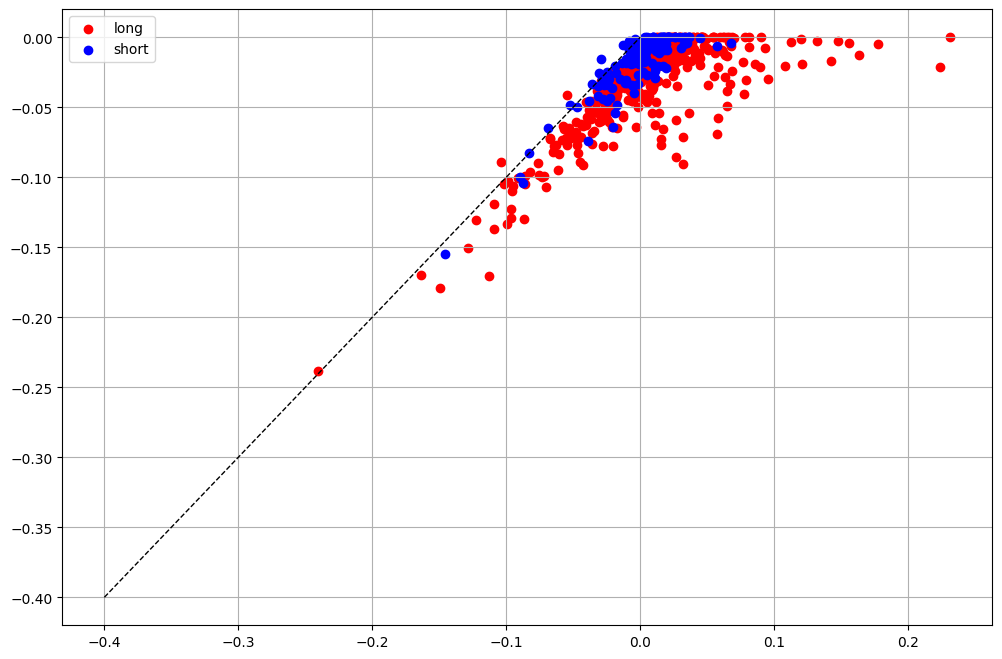

In [3]:
## Checking is stoploss matters?
data = pd.read_csv("../src/logs/lin_reg_train_1h.csv")
print(data.head())

# In the final row of data["signal"], close the position, change it to -np.sum(data["signal"][:-1])
data["signal"].iloc[-1] = -np.sum(data["signal"][:-1])
df_trades = data[data["signal"] != 0]
print(len(df_trades)/2)
index = df_trades.index.to_list()


returns_all = []
returns_low_all = []
trades = []
for i in range(0, len(df_trades), 2):
    prices = data["close"][index[i]: index[i+1]]

    if data["signal"].iloc[index[i]] == 1:
        buy_price = data["close"].iloc[index[i]]
        sell_price = data["close"].iloc[index[i+1]]
        
        if len(prices) > 2:
            returns = (sell_price - buy_price)/buy_price
            returns_all.append(returns)
            low = min(prices[:-1])
            returns_low = (low - buy_price)/buy_price
            returns_low_all.append(returns_low)
            trades.append("long")

    elif data["signal"].iloc[index[i]] == -1:
        sell_price = data["close"].iloc[index[i]]
        buy_price = data["close"].iloc[index[i+1]]

        if len(prices) > 2:
            returns = (sell_price - buy_price)/sell_price
            returns_all.append(returns)
            high = max(prices[:-1])
            returns_low = (sell_price - high)/sell_price
            returns_low_all.append(returns_low)
            trades.append("short")


colors = ['red', 'blue']

plt.figure(figsize=(12,8))
# Create a scatter plot and color code the points based on the labels
for j,trade in enumerate(set(trades)):
    print(trade)
    x_group = [returns_all[i] for i in range(len(returns_all)) if trades[i] == trade]
    y_group = [returns_low_all[i] for i in range(len(returns_all)) if trades[i] == trade]
    color = colors[j]
    plt.scatter(x_group, y_group, label=f'{trade}', c=color)

# also plot x = y line on the plot
x = np.linspace(-0.4, 0, 1000)
plt.plot(x, x, color='black', linestyle='--', linewidth=1)

plt.legend()
plt.grid(True)

In [70]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
import pandas as pd
import sys
import numpy as np


k = 2


def read_file(filename):
    return pd.read_csv(filename, index_col=0, parse_dates=True, infer_datetime_format=True)


def get_data(timeframe, name):
    return read_file("data_with_new_indicators/btcusdt_" + timeframe + "_" + name + ".csv")


# Tick Size of Data
time_frame = "1h"
# Load data
df_train = get_data(time_frame, "train")
df_val = get_data(time_frame, "val")


# Create the linear regression model
model = LinearRegression()


# Define the independent variables
X_train = df_train.drop(f'Next_{k}_Days_Return', axis=1)
X_train = X_train.drop('open', axis=1)
X_train = X_train.drop('close', axis=1)
X_val = df_val.drop(f'Next_{k}_Days_Return', axis=1)
X_val = X_val.drop('open', axis=1)
X_val = X_val.drop('close', axis=1)


# Define the dependent variable
y_train = df_train[f'Next_{k}_Days_Return']
y_val = df_val[f'Next_{k}_Days_Return']
# print(X_train.shape, y_train.shape)
# print(X_val.shape, y_val.shape)


df_train['indicator'] = 0
df_val['indicator'] = 0
# Fit the linear regression model on the training data


model.fit(X_train, y_train)
print("model_coef", model.coef_)


# Predict the dependent variable of the training data
y_pred = model.predict(X_train)
quantile_value = np.quantile(np.abs(y_pred), 0.93)
print("quantile value: ", quantile_value)
print(np.corrcoef(y_pred, y_train)[0,1])
quantile_value = 1.6
# print(df_train['datetime'].head())
df_train['date_time'] = list(pd.to_datetime(pd.Series(df_train.index)))
df_val['date_time'] = list(pd.to_datetime(pd.Series(df_val.index)))


df_train['flag'] = np.where(y_pred > quantile_value, 1, np.where(y_pred < -quantile_value, -1, 0))
print(df_train[df_train['flag'] != 0].tail())
df_fine = pd.read_csv("data_with_new_indicators/btcusdt_3m_train.csv")
df_train = df_train.drop(columns= ["open", "close", "volume"])
df_fine["datetime"] = pd.to_datetime(df_fine["datetime"])
df_fine.rename(columns={'datetime': 'date_time'}, inplace=True)
df_train = df_fine.merge(df_train[['date_time', 'flag']], on='date_time', how='left')
df_train.fillna(0, inplace=True)
df_train.tail()

/tmp/ipykernel_5564/548099301.py:11: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  return pd.read_csv(filename, index_col=0, parse_dates=True, infer_datetime_format=True)
/tmp/ipykernel_5564/548099301.py:11: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  return pd.read_csv(filename, index_col=0, parse_dates=True, infer_datetime_format=True)


model_coef [8.69017981e-05 2.13112354e-02 2.15307275e+00 1.02680307e+00
 1.15511929e+00]
quantile value:  1.634936680497444
0.10185396648465336
                        open    close        volume  Daily_Return  \
datetime                                                            
2020-06-24 15:30:00  9524.65  9378.02   5959.910119    -15.391690   
2020-06-25 08:30:00  9255.01  9100.36  10100.273554    -16.709868   
2020-06-28 00:30:00  9087.76  8938.04   8584.097191    -16.475989   
2020-07-02 20:30:00  9196.02  9048.92   7168.293562    -15.886895   
2020-07-09 20:30:00  9294.19  9208.58   8001.827791     -9.393388   

                     Next_2_Days_Return  RSI  exp_RSI  EMA_Slope  indicator  \
datetime                                                                      
2020-06-24 15:30:00            1.566429  0.0  0.01476   1.689595          0   
2020-06-25 08:30:00            8.679876  0.0  0.01476   1.887104          0   
2020-06-28 00:30:00           13.979575  0.0  0.01476   

,date_time,open,close,volume,Daily_Return,Next_2_Days_Return,RSI,exp_RSI,EMA_Slope,flag
268160,2020-07-24 22:30:00,9575.73,9558.67,330.425928,-1.781587,-3.006694,0.0,0.002934,0.522510,0.0
268161,2020-07-24 22:35:00,9558.98,9544.81,189.869131,-1.449993,-0.693571,0.0,0.002934,0.690450,0.0
268162,2020-07-24 22:40:00,9544.79,9529.93,307.518193,-1.558962,1.371469,0.0,0.002934,0.785245,0.0
268163,2020-07-24 22:45:00,9529.92,9538.19,151.966205,0.866743,0.000000,0.0,0.002934,-0.046051,0.0
268164,2020-07-24 22:50:00,9538.18,9543.00,98.544875,0.504289,0.000000,0.0,0.002934,-0.194732,0.0
